## New York Taxi Fare Prediciton with PyTorch

The goal of this project was to learn how to create neural networks using PyTorch. To do this I selected a relatively simple machine learning project from Kaggle, where the goal is to predict the fare amount for a taxi ride given various different features such as distance, passenger counts, and time of day. Below, I perform some exploratory data analysis, feature engineering, and most importantly model building and training in PyTorch. 

In [26]:
import pandas as pd
from plotnine import *
import math
import patchworklib as pw
import matplotlib.pyplot as plt
from IPython.display import Image

#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg')

In [37]:
train_df = pd.read_csv('train.csv',nrows= 100000)
test_df = pd.read_csv('test.csv')

In [38]:
fare_dist = list(train_df[(train_df.fare_amount < 100) & (train_df.fare_amount > 0)]['fare_amount'])

In [40]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,11.354652,-72.494682,39.914481,-72.490967,39.919053,1.673820
std,9.716777,10.693934,6.225686,10.471386,6.213427,1.300171
min,-44.900000,-736.550000,-74.007670,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992041,40.734996,-73.991215,40.734182,1.000000
50%,8.500000,-73.981789,40.752765,-73.980000,40.753243,1.000000
75%,12.500000,-73.966982,40.767258,-73.963433,40.768166,2.000000
max,200.000000,40.787575,401.083332,40.851027,404.616667,6.000000


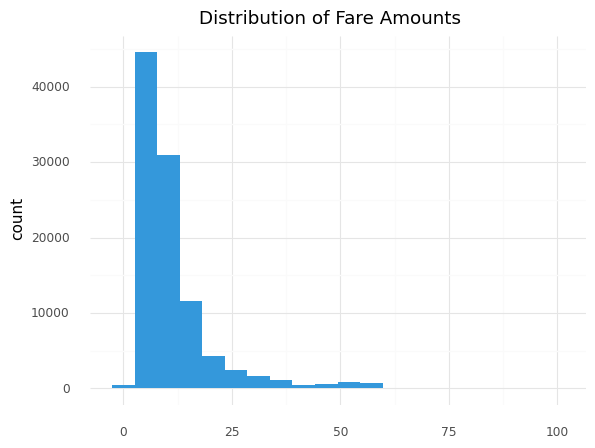

<ggplot: (8788066010323)>

In [39]:
p1 = ggplot() + aes(x=fare_dist) + geom_histogram(fill='#3498db',bins=20) + theme_minimal() + \
labs(title = 'Distribution of Fare Amounts')
p1

Above, we take a look at the outcome variable that we are interested in predicting. We see that most values are less than 10 dollars. 

### Feature Engineering

In this section, we do some feature engineering to add potentially useful variables such as the season, the time of day, and distance metrics based on longitude and latitude.

In [5]:
def return_season(month):
    month = int(month)
    if(month in [12,1,2]):
        return('Winter')
    elif(month in [3,4,5]):
        return('Spring')
    elif(month in [6,7,8]):
        return('Summer')
    elif(month in [9,10,11]):
        return('Fall')
    else:
        return('NA')

In [6]:
def return_time_of_day(hour):
    hour = int(hour)
    if(hour >= 13 and hour <= 18):
        return('Afternoon')
    elif(hour >= 19 or hour <= 5):
        return('Night')
    elif(hour>=6 and hour <= 12):
        return('Morning')
    else:
        return('NA')

In [7]:
def add_features(df):
    
    df['time'] = df['pickup_datetime'].apply(lambda x:x.split(' ')[1])
    df['date'] = df['pickup_datetime'].apply(lambda x:x.split(' ')[0])
    
    df['diff_longitude'] = (df['pickup_longitude']-df['dropoff_longitude']).abs()
    df['diff_latitude'] = (df['pickup_latitude']-df['dropoff_latitude']).abs()
    
    df['hour'] = df['time'].apply(lambda x:x.split(':')[0])
    df['month'] = df['date'].apply(lambda x:int(x.split('-')[1]))
    
    df['time_of_day'] = df['hour'].apply(lambda x:return_time_of_day(x))
    df['season'] = df['month'].apply(lambda x:return_season(x))
    
    tod_dummies = pd.get_dummies(df['time_of_day'])
    season_dummies = pd.get_dummies(df['season'])
    
    df = pd.concat([df,tod_dummies,season_dummies],axis=1)
    
    return df

In [8]:
train_df = add_features(train_df)
test_df = add_features(test_df)

### Exploratory Data Analysis

Below I perform some exploratory data analysis. First, I look for outliers in longitude and latitude. Because these are taxi rides within New York, we see some some values that are impossible and are clearly errors in the data. For that reason, I remove these points because we aren't interested in learning from incorrect data. 

Next, I create visualizations so we can see the distributions of our independent variables.

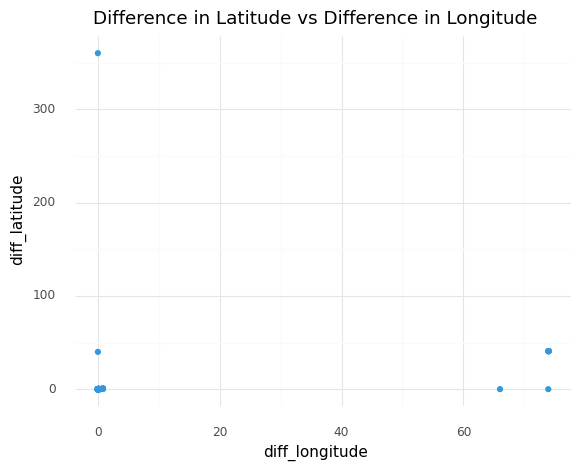

<ggplot: (8787658044817)>

In [9]:
outlier_plot = ggplot(train_df) + aes(x='diff_longitude',y='diff_latitude') + geom_point(fill='#3498db',color='#3498db') + \
theme_minimal() + labs(title = 'Difference in Latitude vs Difference in Longitude')
outlier_plot

In [9]:
train_df = train_df[train_df.diff_longitude < 10]
train_df = train_df[train_df.diff_latitude < 10]

test_df = test_df[test_df.diff_longitude < 10]
test_df = test_df[test_df.diff_latitude < 10]

In [11]:
p2 = ggplot(train_df) + aes(x='passenger_count') + geom_histogram(fill='#E74C3C') + theme_minimal() + \
labs(title = 'Distribution of Passenger Counts')

In [12]:
p3 = ggplot(train_df) + aes(x='diff_longitude') + geom_histogram(fill = '#3498db') + labs(title='Distance (Longitude)') + \
theme_minimal()

p4 = ggplot(train_df) + aes(x='diff_latitude') + geom_histogram(fill = '#3498db') + labs(title='Distance (Latitude)') + \
theme_minimal()

In [13]:
p5 = ggplot(train_df) + aes(x='factor(season)') + geom_bar(fill = '#1ABC9C') + theme_minimal() + \
labs(title='Number of Rides Per Season',x='Season')

p6 = ggplot(train_df) + aes(x='factor(time_of_day)') + geom_bar(fill = '#EB984E') + theme_minimal() + \
labs(title='Number of Rides Per Time of Day',x='Time of Day')

In [14]:
p2 = pw.load_ggplot(p2,figsize=(2.2,2))
p3 = pw.load_ggplot(p3,figsize=(3.3,2))
p4 = pw.load_ggplot(p4,figsize=(3.3,2))
p5 = pw.load_ggplot(p5,figsize=(2.2,2))
p6 = pw.load_ggplot(p6,figsize=(2.2,2))

In [15]:
final_plot = (p3 + p4)/(p2 + p5 + p6)

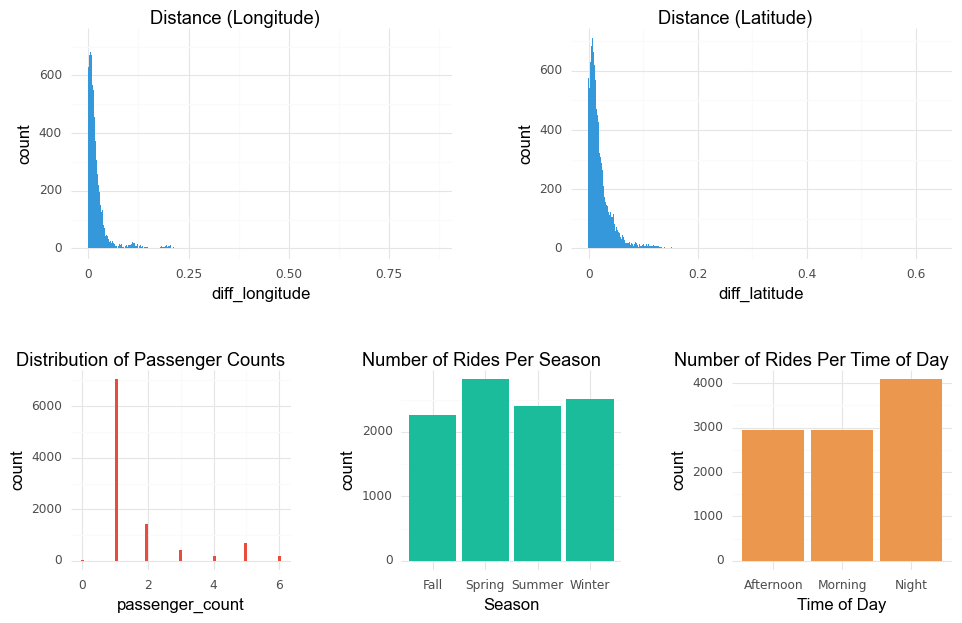

In [16]:
final_plot.savefig()

### Modeling

Finally, in this section, I use PyTorch to create a neural network to perform this prediction task.

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [11]:
#used later when evaluating performance on test set
keys = test_df['key']

In [12]:
#seperating out labels as we do not want to perform feature scaling on these
y_train = train_df['fare_amount'].values

In [13]:
#selecting important independent variables
train_df = train_df[['passenger_count','diff_longitude','diff_latitude','Morning','Afternoon','Night','Fall','Spring','Summer','Winter']]
test_df = test_df[['passenger_count','diff_longitude','diff_latitude','Morning','Afternoon','Night','Fall','Spring','Summer','Winter']]

In [14]:
#performing feature scaling on our independent variables
scaler = MinMaxScaler()
train_df = pd.DataFrame(scaler.fit_transform(train_df))
test_df = pd.DataFrame(scaler.transform(test_df))

In [15]:
X_train = train_df.values
X_test = test_df.values

In [16]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

In [17]:
#using DataLoader to iterate through batches
train_data = Data(X_train,y_train)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=False)

In [18]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 10])
Labels batch shape: torch.Size([32])


In [19]:
#hyperparameters
n_input = 10
n_hidden1 = 10
n_hidden2 = 5
n_hidden3 = 5
n_out = 1
num_epochs = 100
learning_rate = 0.0001

In [20]:
#defining neural network architecture and forward pass

class NeuralNetwork(nn.Module):
    def __init__(self,n_input,n_hidden1,n_hidden2,n_hidden3,n_out):
        super(NeuralNetwork,self).__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_input,n_hidden1),
            nn.ReLU(),
            nn.Linear(n_hidden1,n_hidden2),
            nn.ReLU(),
            nn.Linear(n_hidden2,n_hidden3),
            nn.ReLU(),
            nn.Linear(n_hidden3,n_out)
        )
    
    def forward(self,x):
        outputs = self.linear_relu_stack(x)
        return outputs

In [21]:
model = NeuralNetwork(n_input,n_hidden1,n_hidden2,n_hidden3,n_out)

In [22]:
#defining loss function and optimizer

loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [23]:
#performing training

loss_values = []

for epoch in range(num_epochs):
    for X, y in train_dataloader: 

        optimizer.zero_grad()
        
        
        pred = model(X)
        loss = loss_function(pred, y.unsqueeze(-1))
        
        loss.backward()
        optimizer.step()
    loss_values.append(loss.item())
print("Training Complete")

Training Complete


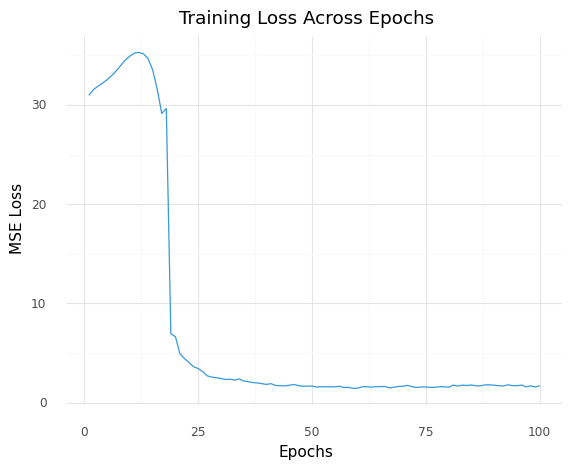

<ggplot: (8788049990641)>

In [41]:
step = range(1,num_epochs+1,1)
#np.linspace(0,num_epochs,1)

ggplot() + aes(x=step,y=loss_values) + geom_line(color='#3498db') + \
theme_minimal() + labs(title = 'Training Loss Across Epochs',x='Epochs',y='MSE Loss')

In [30]:
#generate predictions and format the way Kaggle wants it
X_test = torch.from_numpy(X_test.astype(np.float32))
outputs = model(X_test)
fare_amount = outputs.detach().numpy().flatten()
preds = pd.DataFrame([keys,fare_amount]).transpose()
preds.columns = ['key','fare_amount']

In [48]:
#saving predictions to file
preds.to_csv('preds.csv',index=False)

As this was a Kaggle challenge, I did not have access to the test labels to analyze performance directly in this notebook. However, I did submit my predictions to Kaggle and received a score lower than the baseline model they provided that uses solely distance metrics. Their baseline recieves an average RMSE of 6.5 on the test set (depends on which model type you use). As you can see in the image below, my neural network received an RMSE of 4.47.

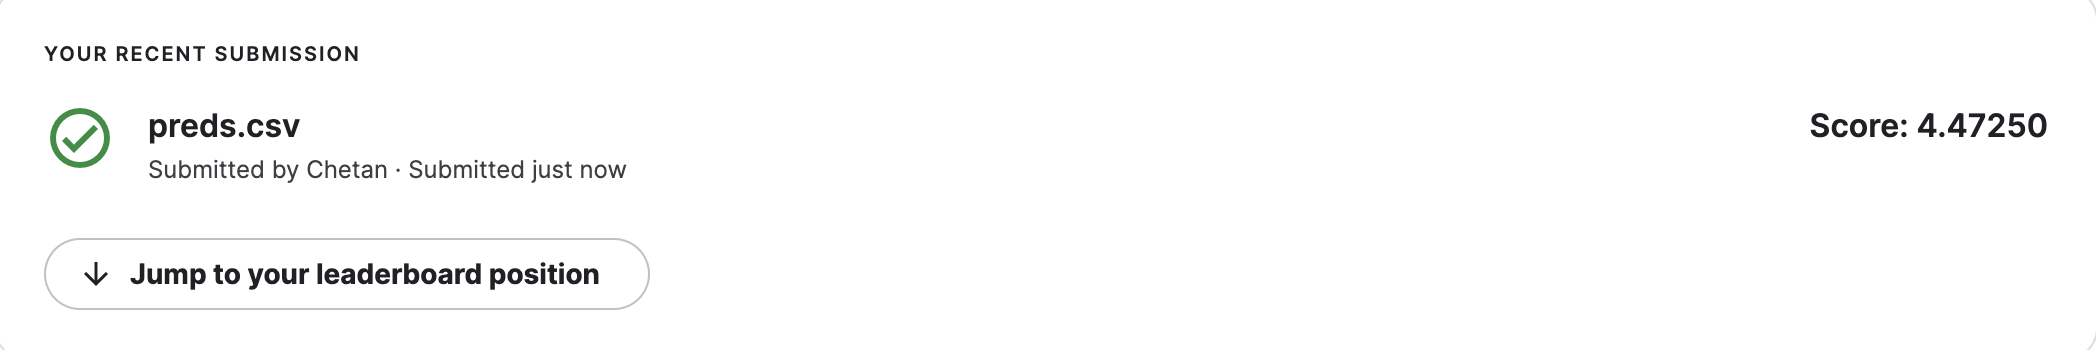

In [52]:
Image(filename='kaggle_score.png') 